### classification results (baseline vs sparse classifier)

- exp_setup: 
    - training 
    - testing

- result: performance of single layer probes for detecting harm
    - acts probe: "baseline"
        - test accuracy
        - test recall
    - sparse acts probe: "sparse probe"
        - test accuracy
        - test recall

In [3]:
import random
import torch as t
from torch import nn
from sae_lens import HookedSAETransformer
import matplotlib.pyplot as plt

from utils.data_utils import read_from_json_file, read_from_pt_gz
from utils.probe_utils import data_loader, train_probe, test_probe

/opt/miniconda3/envs/causal-interp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### set up

In [46]:
class Probe(nn.Module):
    def __init__(self, activation_dim):
        super().__init__()
        self.net = nn.Linear(activation_dim, 1, bias=True)

    def forward(self, x):
        logits = self.net(x).squeeze(-1)
        return logits

In [18]:
## load pythia with hooked transformer for consistent comparison

device = "cpu"
pythia_model: HookedSAETransformer = HookedSAETransformer.from_pretrained('EleutherAI/pythia-70m-deduped', device=device)

Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


### acts probe: trained over 200 epoches

In [105]:
### get train acts
nonharmful_acts = read_from_pt_gz("data_latents/train/acts/nonharmful_acts_512.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/train/acts/harmful_acts_512.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )

train_batches = data_loader(last_tok_acts_data, label)
len(train_batches)

8

In [104]:
## get test acts
nonharmful_acts = read_from_pt_gz("data_latents/test/acts/nonharmful_acts_512.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/test/acts/harmful_acts_512.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )
test_batches = data_loader(last_tok_acts_data, label)
len(test_batches)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


24

In [19]:
t.manual_seed(42)
probe = Probe(512)

epoch_train_loss = []
total_loss = []
epoch_test_acc = []
epoches = 200

# train_batches = batches[:-2]

for i in range(epoches): 
    probe, losses = train_probe(probe, train_batches)
    total_loss.extend(losses)
    epoch_train_loss.append(losses[-1])

    test_acc = test_probe(probe, batches=test_batches, seed=42)
    epoch_test_acc.append(test_acc)


[0.4401041567325592, 0.53125, 0.6197916865348816, 0.7291666865348816, 0.6666666865348816, 0.5677083134651184, 0.8697916865348816, 0.6979166865348816, 0.6458333134651184, 0.8645833134651184, 0.7526041865348816, 0.7083333134651184, 0.7421875, 0.7578125, 0.8072916865348816, 0.7786458134651184, 0.7604166865348816, 0.828125, 0.71875, 0.8854166865348816, 0.7473958134651184, 0.8098958134651184, 0.8619791865348816, 0.7916666865348816, 0.8229166865348816, 0.7916666865348816, 0.7057291865348816, 0.8984375, 0.8255208134651184, 0.6979166865348816, 0.8854166865348816, 0.8177083134651184, 0.6953125, 0.8880208134651184, 0.8151041865348816, 0.828125, 0.9166666865348816, 0.8541666865348816, 0.7526041865348816, 0.90625, 0.8203125, 0.7369791865348816, 0.9036458134651184, 0.8229166865348816, 0.8854166865348816, 0.8203125, 0.7916666865348816, 0.8723958134651184, 0.8385416865348816, 0.9244791865348816, 0.8333333134651184, 0.7526041865348816, 0.890625, 0.7526041865348816, 0.8958333134651184, 0.74739581346511

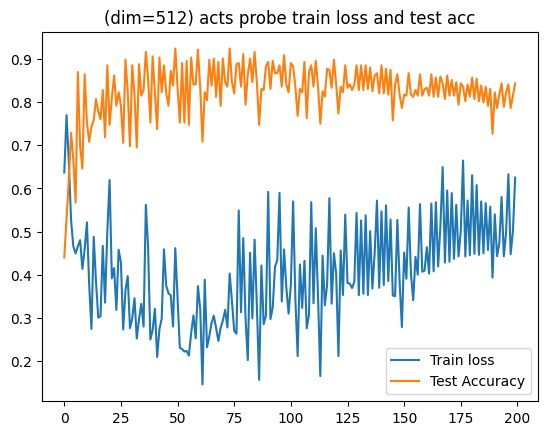

In [ ]:
plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")
plt.legend()
plt.title("(dim=512) acts probe train loss and test acc")
print(epoch_test_acc)

Text(0.5, 1.0, '(dim=512) total loss')

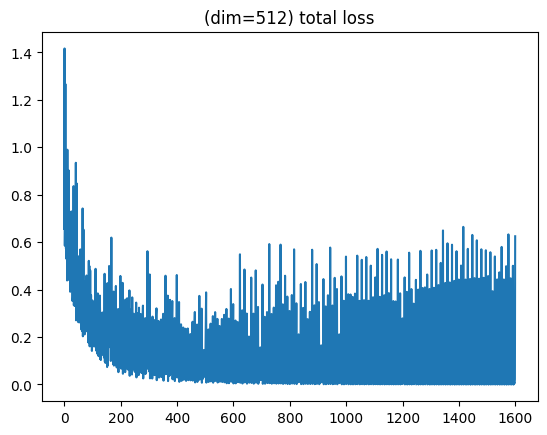

In [ ]:
plt.plot(total_loss, label="total loss")
plt.title("(dim=512) total loss")

In [ ]:
print("test accuracy (top 3)", t.tensor(epoch_test_acc).topk(3)) # test accuracy seem to have peaked at 49/73
print("train loss (bottom 3)", t.tensor(epoch_train_loss).topk(3, largest=False))



test accuracy (top 3) torch.return_types.topk(
values=tensor([0.9245, 0.9245, 0.9219]),
indices=tensor([49, 73, 59]))
train loss (bottom 3) torch.return_types.topk(
values=tensor([0.1456, 0.1563, 0.1650]),
indices=tensor([ 61,  86, 113]))


### acts probe: 65 epoches

In [49]:
t.manual_seed(42)
probe = Probe(512)

epoch_train_loss = []
total_loss = []
epoch_test_acc = []
epoches = 65

# train_batches = batches[:-2]

for i in range(epoches): 
    probe, losses = train_probe(probe, train_batches)
    total_loss.extend(losses)
    epoch_train_loss.append(losses[-1])

    test_acc = test_probe(probe, batches=test_batches, seed=42)
    epoch_test_acc.append(test_acc)

In [108]:
test_probe(probe, batches=test_batches, seed=42)


0.8984375

Text(0.5, 1.0, 'Acts probe (dim=512) training plot (Final test accuracy = 0.8984) ')

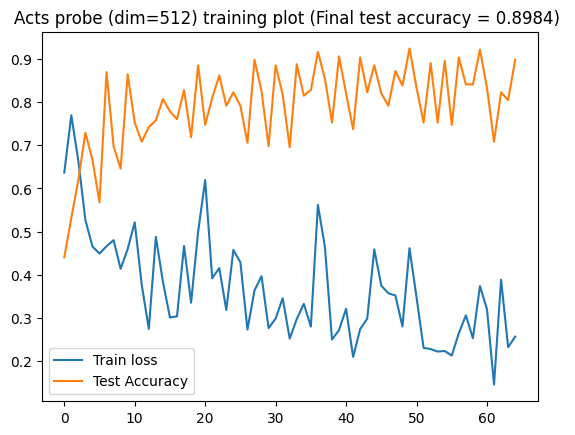

In [ ]:
plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")
plt.legend()
plt.title(f"Acts probe (dim=512) training plot (Final test accuracy = {epoch_test_acc[-1]:.4f}) ")


#### acts probe recall

In [76]:
## recall score (harmful) = 0.823

harmful_acts = read_from_pt_gz("data_latents/test/acts/harmful_acts_512.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

recall = test_probe(probe, test_batches_harmful)
print('Recall', recall)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


Recall (0.8229166865348816, [tensor([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.]), tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]), tensor([1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.]), tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.]), tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.]), tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.]), tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.]), tensor([1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.]), tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.])])


In [ ]:
## recall score (nonharmful) = 0.97
## better at nonharmful than harmful?

nonharmful_acts = read_from_pt_gz("data_latents/test/acts/nonharmful_acts_512.pt.gz")
last_tok_acts_data = nonharmful_acts[:, -1, :].tolist()

label = t.zeros(len(nonharmful_acts))
test_batches_nonharmful = data_loader(last_tok_acts_data, label)

test_probe(probe, test_batches_nonharmful)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


0.9739583134651184

In [ ]:
# recall (perturbed)
harmful_acts = read_from_pt_gz("data_latents/test_perturbed/acts/harmful_acts_512.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful_perturbed = data_loader(last_tok_acts_data, label)

test_probe(probe, test_batches_harmful_perturbed)

# plt.plot(harmful_acts[:, -1, :].mean(0))

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


0.0

In [109]:
filepath = "concept_probe/acts_probe/acts_probe.pth"
t.save(probe.state_dict(), filepath)
print('saved to ', filepath)


saved to  concept_probe/acts_probe/acts_probe.pth


In [ ]:
from utils.probe_utils import load_probe

probe_90 = load_probe("concept_probe/probe_dim_512_test_acc_0.9062.pth")
# test_probe(probe_90, test_batches_harmful)
# bc this probe was trained on a diff distribution
# it doesnt do well on this?
# test_probe(probe_90, test_batches_nonharmful)
test_probe(probe_90, test_batches)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/probe_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(filepath))


0.5026041865348816

### sparse acts probe: 65 epoch


In [116]:
### get train acts
nonharmful_acts = read_from_pt_gz("data_latents/train/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/train/sparse_acts/harmful_sparse_acts_32768.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )

train_batches = data_loader(last_tok_acts_data, label)

In [117]:
## get test acts
nonharmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/harmful_sparse_acts_32768.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )
test_batches = data_loader(last_tok_acts_data, label)
len(test_batches)

24

In [87]:
t.manual_seed(42)
probe = Probe(32768)

epoch_train_loss = []
total_loss = []
epoch_test_acc = []
epoches = 65

# train_batches = batches[:-2]

for i in range(epoches): 
    probe, losses = train_probe(probe, train_batches)
    total_loss.extend(losses)
    epoch_train_loss.append(losses[-1])

    test_acc = test_probe(probe, batches=test_batches, seed=42)
    epoch_test_acc.append(test_acc)

In [91]:
t.tensor(epoch_test_acc).topk(3)

torch.return_types.topk(
values=tensor([0.7812, 0.7734, 0.7682]),
indices=tensor([3, 2, 4]))

Text(0.5, 1.0, 'Sparse acts probe training plot (Final test accuracy = 0.7318) ')

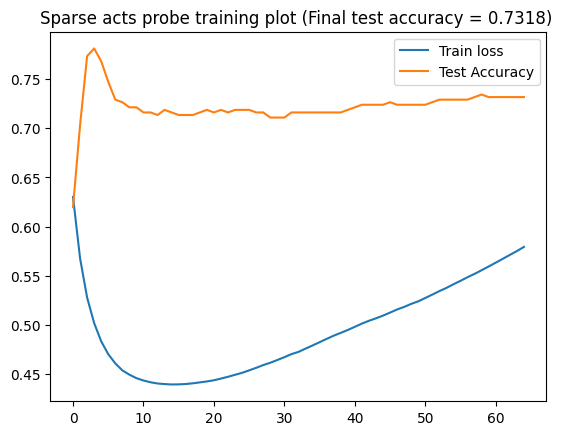

In [89]:
plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")
plt.legend()
plt.title(f"Sparse acts probe training plot (Final test accuracy = {epoch_test_acc[-1]:.4f}) ")


In [92]:
## test acts 
## accuracy
test_probe(probe, batches=test_batches, seed=42)


0.7317708134651184

In [93]:
harmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

recall = test_probe(probe, test_batches_harmful)
print("test harmful recall:", recall)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


test harmful recall: 0.6927083134651184


In [94]:
harmful_acts = read_from_pt_gz("data_latents/test_perturbed/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

recall = test_probe(probe, test_batches_harmful)
print("test harmful perturbed recall:", recall)

test harmful perturbed recall: 0.5729166865348816


In [ ]:
## test nonharmful

nonharmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = nonharmful_acts[:, -1, :].tolist()
label = t.zeros(len(nonharmful_acts))
test_batches_nonharmful = data_loader(last_tok_acts_data, label)

test_probe(probe, test_batches_nonharmful)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


0.7708333134651184

In [102]:
filepath = "concept_probe/sparse_acts_probe/sparse_acts_probe.pth"
t.save(probe.state_dict(), filepath)
print('saved to ', filepath)


saved to  concept_probe/sparse_acts_probe/sparse_acts_probe.pth


### 3 epoches: sparse acts highest scored epoch

In [118]:
t.manual_seed(42)
probe = Probe(32768)

epoch_train_loss = []
total_loss = []
epoch_test_acc = []
epoches = 3

# train_batches = batches[:-2]

for i in range(epoches): 
    probe, losses = train_probe(probe, train_batches)
    total_loss.extend(losses)
    epoch_train_loss.append(losses[-1])

    test_acc = test_probe(probe, batches=test_batches, seed=42)
    epoch_test_acc.append(test_acc)

Text(0.5, 1.0, 'Sparse Acts probe training plot (Final test accuracy = 0.7734) ')

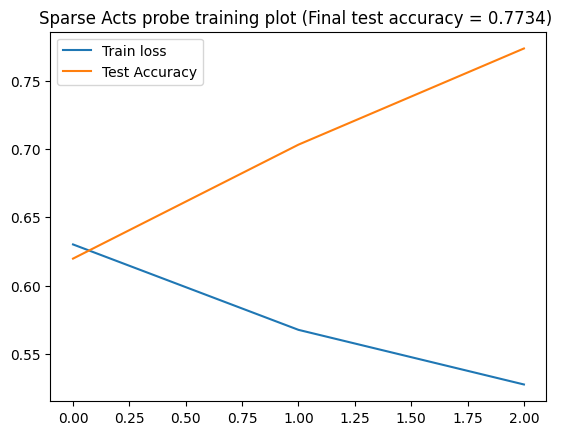

In [119]:
plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")
plt.legend()
plt.title(f"Sparse Acts probe training plot (Final test accuracy = {epoch_test_acc[-1]:.4f}) ")



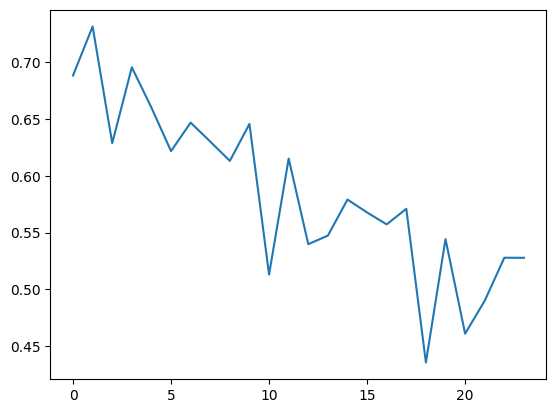

In [121]:
plt.plot(total_loss)

In [120]:
# recall (harmful)
harmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

recall = test_probe(probe, test_batches_harmful)

# recall (perturbed)
harmful_acts = read_from_pt_gz("data_latents/test_perturbed/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful_perturbed = data_loader(last_tok_acts_data, label)

perturbed_recall = test_probe(probe, test_batches_harmful_perturbed)

test_acc = test_probe(probe, batches=test_batches, seed=42)

print("test accuracy: ", test_acc)
print("recall: ", recall)
print("recall perturbed: ", perturbed_recall)

test accuracy:  0.7734375
recall:  0.9114583134651184
recall perturbed:  0.796875


In [ ]:
nonharmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = nonharmful_acts[:, -1, :].tolist()

label = t.zeros(len(nonharmful_acts))
test_batches_nonharmful = data_loader(last_tok_acts_data, label)

test_probe(probe, test_batches_nonharmful)

# t.save(probe.state_dict(), filepath)
# print('saved to ', filepath)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


0.6354166865348816

In [126]:
test_probe(probe, test_batches_nonharmful)


0.6354166865348816

In [124]:
filepath = "concept_probe/sparse_acts_probe/sparse_acts_probe_3_epoches.pth"
t.save(probe.state_dict(), filepath)
print('saved to ', filepath)


saved to  concept_probe/sparse_acts_probe/sparse_acts_probe_3_epoches.pth
